In [1]:
import random
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import pycountry_convert as pc

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


import logging
optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.CRITICAL)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           367441 non-null  object 
 1   ARI_CO              367441 non-null  object 
 2   ARI_PO              367441 non-null  object 
 3   SHIP_TYPE_CATEGORY  367441 non-null  object 
 4   DIST                367441 non-null  float64
 5   ATA                 367441 non-null  object 
 6   ID                  367441 non-null  object 
 7   BREADTH             367440 non-null  float64
 8   BUILT               367441 non-null  int64  
 9   DEADWEIGHT          367441 non-null  int64  
 10  DEPTH               367440 non-null  float64
 11  DRAUGHT             367440 non-null  float64
 12  GT                  367441 non-null  int64  
 13  LENGTH              367440 non-null  float64
 14  SHIPMANAGER         367441 non-null  object 
 15  FLAG                367441 non-nul

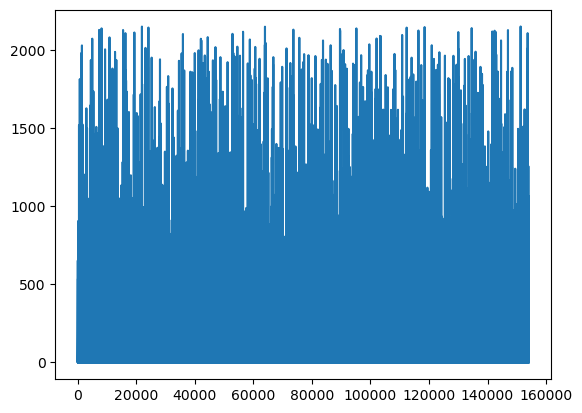

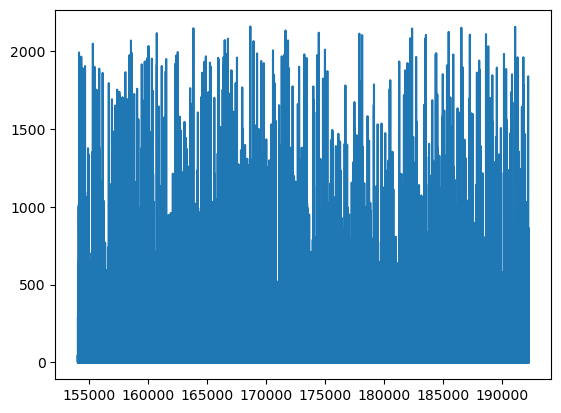

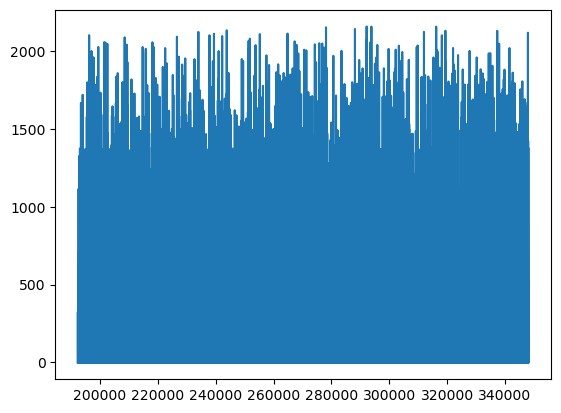

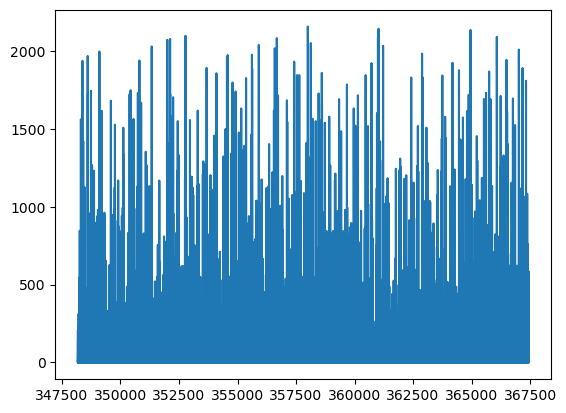

In [3]:
target = 'SHIP_TYPE_CATEGORY'
train = train.sort_values(target).reset_index(drop=True)
for i in train[target].unique():
    plt.plot(train[train[target]==i]['CI_HOUR'])
    plt.show()

In [4]:
train['CI_HOUR'] - train['ATA_LT']

0          -8.951667
1         121.238889
2          17.739167
3         -15.000000
4          26.012500
             ...    
367436      5.383056
367437     84.577778
367438    -12.000000
367439    104.551667
367440     92.463056
Length: 367441, dtype: float64

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244989 entries, 0 to 244988
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           244989 non-null  object 
 1   ARI_CO              244989 non-null  object 
 2   ARI_PO              244989 non-null  object 
 3   SHIP_TYPE_CATEGORY  244989 non-null  object 
 4   DIST                244989 non-null  float64
 5   ATA                 244989 non-null  object 
 6   ID                  244989 non-null  object 
 7   BREADTH             244989 non-null  float64
 8   BUILT               244989 non-null  int64  
 9   DEADWEIGHT          244989 non-null  int64  
 10  DEPTH               244989 non-null  float64
 11  DRAUGHT             244989 non-null  float64
 12  GT                  244989 non-null  int64  
 13  LENGTH              244989 non-null  float64
 14  SHIPMANAGER         244989 non-null  object 
 15  FLAG                244989 non-nul

In [6]:
def prep_continent(df):
    ans = []
    for i in [i for i in df['FLAG']]:
        try:
            ans.append(country_to_continent(i))
        except:
            if 'Ch' in i or 'Korea' in i:
                ans.append('Asia')
            elif 'Portugal' in i or 'Denmark' in i or 'France' in i or 'Norway' in i or 'Isle Of Man' in i or 'Irish' in i or 'Spain' in i or 'Faeroes' in i:
                ans.append('Europe')
            elif 'Antigua & Barbuda' in i or 'United States Of America' in i or 'St Kitts & Nevis' in i or 'St Vincent & The Grenadines' in i:
                ans.append('North America')
            elif 'Tanzania' in i or 'Sao Tome & Principe' in i or 'Togo' in i or 'Comoros' in i:
                ans.append('Africa')
            elif 'Guyana' in i:
                ans.append('North America')
            else:
                ans.append('Unknown')
    return ans

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop(['SAMPLE_ID','ID'],axis=1)
test = test.drop(['SAMPLE_ID','ID'],axis=1)
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    # df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns=['ATA','SHIPMANAGER'], inplace=True)
test.drop(columns=['ATA','SHIPMANAGER'], inplace=True)

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

train['FLAG'] = prep_continent(train)     
test['FLAG'] = prep_continent(test)

targets = ['ARI_CO','ARI_PO','FLAG','SHIP_TYPE_CATEGORY']
for target in targets:
    categories = train[target].unique()

    # OneHotEncoder 객체 생성
    encoder = OneHotEncoder(sparse=False)

    # 범주형 데이터를 정수로 변환 (숫자로 변환해야 OneHotEncoder 사용 가능)
    encoder.fit(train[[target]])
    categories_int =  encoder.transform(train[[target]])
    train = pd.concat([train,pd.DataFrame(categories_int,columns=categories)],axis=1)
    train = train.drop(target,axis=1)

    categories_int = encoder.transform(test[[target]])
    test = pd.concat([test,pd.DataFrame(categories_int,columns=categories)],axis=1)
    test = test.drop(target,axis=1)

train['U_WIND'] = train['U_WIND'].fillna('null')
train['AIR_TEMPERATURE'] = train['AIR_TEMPERATURE'].fillna('null')

train_air = train[train['U_WIND'] != 'null']
tp = train[train['U_WIND'] != 'null']
tp_train = tp[tp['AIR_TEMPERATURE'] != 'null']
tp_train = tp_train.dropna()
tp_train['U_WIND'] = tp_train['U_WIND'].astype('float32')
tp_train['AIR_TEMPERATURE'] = tp_train['AIR_TEMPERATURE'].astype('float32')

tp_test = tp[tp['AIR_TEMPERATURE'] == 'null']
tp_test = tp_test.drop('AIR_TEMPERATURE',axis=1)

# rg = CatBoostRegressor(random_state=44)
# rg.fit(tp_train)
# rg.predict(tp_test)

test_air = test[test['U_WIND'] != 'null']
train_not_air = train.loc[[i for i in train.index if i not in train_air.index],:]
test_not_air = test.loc[[i for i in test.index if i not in test_air.index],:]
train_not_air = train_not_air.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN'],axis=1)
test_not_air = test_not_air.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN'],axis=1)

In [31]:
from pycaret import regression

regression.setup(data=tp_train,
                     target='AIR_TEMPERATURE',
                     session_id=77)
#                     outliers_method='iforest')

best = regression.compare_models(n_select=5,fold=5,sort='MAE')

,Description,Value
0,Session id,77
1,Target,AIR_TEMPERATURE
2,Target type,Regression
3,Original data shape,"(213075, 163)"
4,Transformed data shape,"(213075, 163)"
5,Transformed train set shape,"(149152, 163)"
6,Transformed test set shape,"(63923, 163)"
7,Numeric features,162
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.5419,5.7623,2.4004,0.9390,0.2697,0.2544,75.6620
rf,Random Forest Regressor,1.5822,5.8825,2.4252,0.9377,0.2720,0.2653,80.3740
catboost,CatBoost Regressor,1.8639,6.6167,2.5721,0.9300,0.2923,0.3081,14.1380
xgboost,Extreme Gradient Boosting,1.9737,7.4581,2.7306,0.9210,0.2987,0.3311,22.3740
dt,Decision Tree Regressor,2.1180,12.0303,3.4683,0.8726,0.3412,0.3486,6.6860
lightgbm,Light Gradient Boosting Machine,2.1499,8.6968,2.9488,0.9079,0.3178,0.3663,6.1040
gbr,Gradient Boosting Regressor,3.4225,20.8498,4.5660,0.7793,0.4320,0.7026,21.7820
lr,Linear Regression,5.0995,43.1031,6.5652,0.5437,0.5619,1.0463,6.1240
ridge,Ridge Regression,5.0996,43.1029,6.5652,0.5437,0.5618,1.0465,5.5940
br,Bayesian Ridge,5.0997,43.1030,6.5652,0.5437,0.5618,1.0469,5.8560


In [10]:
from pycaret.regression import *
from sklearn.tree import ExtraTreeRegressor
from pycaret import regression

# param_grid = {
#     'C': [0.1, 1, 10],
#     'max_iter': [100, 200, 300]
# }

# tuned_model = tune_model('lr', fold=5, custom_grid=param_grid)
regression.setup(data=tp_train,
                     target='AIR_TEMPERATURE',
                     session_id=77)
#                     outliers_method='iforest')
rg = ExtraTreeRegressor(random_state=77)
# rg.fit(tp_train.drop('AIR_TEMPERATURE',axis=1),tp_train['AIR_TEMPERATURE'])
best_tune = tune_model(rg, fold=5, optimize='MAE')

,Description,Value
0,Session id,77
1,Target,AIR_TEMPERATURE
2,Target type,Regression
3,Original data shape,"(213075, 163)"
4,Transformed data shape,"(213075, 163)"
5,Transformed train set shape,"(149152, 163)"
6,Transformed test set shape,"(63923, 163)"
7,Numeric features,162
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.3063,52.4380,7.2414,0.4419,0.5686,1.0680
1,5.3435,53.4711,7.3124,0.4303,0.5662,1.0499
2,5.5150,55.6005,7.4566,0.4118,0.5755,1.0617
3,5.5858,56.4034,7.5102,0.4123,0.5917,1.1484
4,5.5250,55.5420,7.4527,0.4087,0.5734,1.0907
Mean,5.4551,54.6910,7.3946,0.4210,0.5751,1.0837
Std,0.1097,1.4865,0.1008,0.0129,0.0089,0.0350


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [13]:
best_tune.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 77,
 'splitter': 'random'}

In [18]:
tp_test['AIR_TEMPERATURE'] = best_tune.predict(tp_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AIR_TEMPERATURE


In [24]:
tp_test = pd.concat([tp_train,tp_test])


In [28]:
tp_test.to_csv('./temperature_train.csv')

In [30]:
train_not_air.to_csv('./Ntemperature_train.csv')

In [70]:
train = pd.read_csv('./train.csv')
train = train.fillna('null')
tp = train[train['U_WIND'] != 'null']
tp_test = tp[tp['AIR_TEMPERATURE'] == 'null']
tp[tp['AIR_TEMPERATURE'] != 'null']


,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,TRAIN_000000,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,TRAIN_000001,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,TRAIN_000002,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,...,0.0,9.4,0.0,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,TRAIN_000004,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367434,TRAIN_367434,CN,QQW1,Bulk,55.408765,2022-06-16 14:27,D236761,30.0,16,26500,...,0.96,28.2,2.651752,22,108.43,114.13,109.56,2067.433444,0.000595,83.960833
367437,TRAIN_367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,TRAIN_367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,TRAIN_367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


** stratgy
- train data 를 두조각으로 분리 : 풍향이 있는경우, 없는경우
- 풍향이있는경우 온도의 빈값은 머신러닝으로 예측
- FLAG 컬럼 대륙변환 시킨경우와 안시킨경우 학습

In [6]:
pd.read_csv('./data_info - Column Desc.csv')

,Feature Name,Description,단위,비고
0,ARI_CO,도착항의 소속국가(도착항 앞 2글자),NaN,NaN
1,ARI_PO,도착항의 항구명(도착항 뒤 글자),NaN,NaN
2,SHIP_TYPE_CATEGORY,선종 통합 바탕으로 5대 선종으로 분류,NaN,NaN
3,DIST,정박지(ber_port)와 접안지 사이의 거리,km,NaN
4,ATA,anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of...,hour,NaN
5,ID,선박식별 일련번호,NaN,NaN
6,BREADTH,선박의 폭,m,NaN
7,BUILT,선박의 연령,year,NaN
8,DEADWEIGHT,선박의 재화중량톤수,ton,NaN
9,DEPTH,선박의 깊이,m,NaN


In [7]:
train

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,...,ONW1,XZF6,RGT8,Asia,Africa,Oceania,North America,Europe,Unknown,South America
0,30.736578,30.0,28,73100,20.0,10.0,38600,220.0,0.14,3.77,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,63.220425,30.0,15,37900,20.0,10.0,28100,220.0,-3.16,-6.72,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,90.427421,50.0,7,115000,20.0,10.0,96400,300.0,0.00,0.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,10.0,33,1490,10.0,0.0,700,70.0,4.34,-7.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,8.813725,30.0,10,27600,10.0,10.0,19300,180.0,1.92,2.31,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,59.018184,40.0,13,93200,20.0,10.0,51300,230.0,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
367437,0.000000,10.0,9,1280,0.0,0.0,500,60.0,-0.06,0.87,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
367438,1.768630,30.0,6,25000,20.0,10.0,25100,180.0,-0.63,3.36,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
367439,0.000000,10.0,8,2400,10.0,0.0,750,80.0,3.74,-2.44,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# set(train['ID'].unique())

In [9]:
# print(len(test['ID'].unique()))
# len(set(test['ID'].unique()).intersection(set(train['ID'].unique())))

In [10]:
train.columns

Index(['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT',
       'LENGTH', 'U_WIND', 'V_WIND',
       ...
       'ONW1', 'XZF6', 'RGT8', 'Asia', 'Africa', 'Oceania', 'North America',
       'Europe', 'Unknown', 'South America'],
      dtype='object', length=164)

In [11]:
# col_name = 'ARI_PO'
# train = train.dropna()
# test = test.dropna()
# train_ratio = [i/len(train) for i in train.groupby(col_name).count()['SAMPLE_ID'].to_dict().values()]
# test_ratio = [i/len(test) for i in test.groupby(col_name).count()['SAMPLE_ID'].to_dict().values()]
# [(train_ratio[i]-test_ratio[i])*100 for i in range(len(train_ratio))]
# train.groupby(col_name).count()['SAMPLE_ID'].to_dict().keys() == test.groupby(col_name).count()['SAMPLE_ID'].to_dict().keys()

In [12]:
pd.read_csv('./data_info - Column Desc.csv')

,Feature Name,Description,단위,비고
0,ARI_CO,도착항의 소속국가(도착항 앞 2글자),NaN,NaN
1,ARI_PO,도착항의 항구명(도착항 뒤 글자),NaN,NaN
2,SHIP_TYPE_CATEGORY,선종 통합 바탕으로 5대 선종으로 분류,NaN,NaN
3,DIST,정박지(ber_port)와 접안지 사이의 거리,km,NaN
4,ATA,anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of...,hour,NaN
5,ID,선박식별 일련번호,NaN,NaN
6,BREADTH,선박의 폭,m,NaN
7,BUILT,선박의 연령,year,NaN
8,DEADWEIGHT,선박의 재화중량톤수,ton,NaN
9,DEPTH,선박의 깊이,m,NaN


In [13]:
from pycaret import regression

regression.setup(data=train_air,
                     target='CI_HOUR',
                     fold_strategy='kfold',
                     train_size=0.8,
                     session_id=77,
                     remove_outliers=True,
                     outliers_threshold=0.05,
                     feature_selection = True,
                     n_features_to_select=0.5)
#                     outliers_method='iforest')

best = regression.compare_models(n_select=5,fold=5,sort='MAE')

,Description,Value
0,Session id,77
1,Target,CI_HOUR
2,Target type,Regression
3,Original data shape,"(213075, 164)"
4,Transformed data shape,"(204552, 82)"
5,Transformed train set shape,"(161937, 82)"
6,Transformed test set shape,"(42615, 82)"
7,Numeric features,163
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,36.8843,7934.4506,84.4845,0.6467,1.4290,5.3376,14.3600
xgboost,Extreme Gradient Boosting,45.4843,11894.6996,108.9776,0.6216,1.5994,6.4308,17.0600
lightgbm,Light Gradient Boosting Machine,54.4520,18687.9073,136.6399,0.4052,1.3632,8.3329,5.6800
huber,Huber Regressor,58.3477,32347.0988,179.8001,-0.0299,1.5290,1.2856,7.5890
et,Extra Trees Regressor,59.6784,22691.2810,150.6010,0.2772,1.2134,8.3092,51.8190
rf,Random Forest Regressor,60.7844,23202.9410,152.2947,0.2607,1.1775,9.8507,86.1260
gbr,Gradient Boosting Regressor,64.5847,25006.1329,158.0869,0.2038,1.7380,9.2724,21.8050
ridge,Ridge Regression,73.6594,27965.9201,167.1749,0.1097,2.3826,6.5477,5.8720
br,Bayesian Ridge,73.6635,27973.2461,167.1970,0.1095,2.3836,6.5343,6.0190
lr,Linear Regression,73.8624,27843.0776,166.8086,0.1136,2.3797,6.8314,7.0210


In [14]:
from pycaret import regression

regression.setup(data=train_not_air,
                     target='CI_HOUR',
                     fold_strategy='kfold',
                     train_size=0.8,
                     session_id=77,
                     remove_outliers=True,
                     outliers_threshold=0.05,
                     feature_selection = True,
                     n_features_to_select=0.5)
#                     outliers_method='iforest')

best = regression.compare_models(n_select=5,fold=5,sort='MAE')

,Description,Value
0,Session id,77
1,Target,CI_HOUR
2,Target type,Regression
3,Original data shape,"(154366, 160)"
4,Transformed data shape,"(148191, 80)"
5,Transformed train set shape,"(117317, 80)"
6,Transformed test set shape,"(30874, 80)"
7,Numeric features,159
8,Rows with missing values,0.0%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,41.2943,10432.5854,102.1027,0.6052,1.5886,6.5550,12.0680
xgboost,Extreme Gradient Boosting,42.8979,12123.9416,110.0891,0.5410,1.5560,6.8510,11.8940
lightgbm,Light Gradient Boosting Machine,46.7541,15917.7249,126.1360,0.3976,1.3007,8.6098,5.7260
et,Extra Trees Regressor,49.5369,17940.4521,133.9012,0.3209,1.1389,8.4866,27.6940
rf,Random Forest Regressor,49.8230,18039.2213,134.2800,0.3172,1.0920,9.9520,36.4060
huber,Huber Regressor,51.0848,27384.4379,165.4487,-0.0362,1.5232,1.3115,5.9400
gbr,Gradient Boosting Regressor,55.3453,20467.7035,143.0228,0.2256,1.7417,9.4530,13.5680
dt,Decision Tree Regressor,62.5481,37130.2934,192.6555,-0.4065,1.1856,9.9372,5.6100
en,Elastic Net,65.4018,24807.2727,157.4696,0.0613,2.4571,5.0672,5.7720
lasso,Lasso Regression,65.5708,24118.0372,155.2647,0.0875,2.4641,5.7261,5.4980


In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop(['SAMPLE_ID','ID'],axis=1)
test = test.drop(['SAMPLE_ID','ID'],axis=1)
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns=['ATA','SHIPMANAGER'], inplace=True)
test.drop(columns=['ATA','SHIPMANAGER'], inplace=True)

# def country_to_continent(country_name):
#     country_alpha2 = pc.country_name_to_country_alpha2(country_name)
#     country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
#     country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
#     return country_continent_name

# train['FLAG'] = prep_continent(train)     
# test['FLAG'] = prep_continent(test)

targets = ['SHIP_TYPE_CATEGORY','ARI_CO','ARI_PO']
for target in targets:
    categories = train[target].unique()

    # OneHotEncoder 객체 생성
    encoder = OneHotEncoder(sparse=False)

    # 범주형 데이터를 정수로 변환 (숫자로 변환해야 OneHotEncoder 사용 가능)
    encoder.fit(train[[target]])
    categories_int =  encoder.transform(train[[target]])
    train = pd.concat([train,pd.DataFrame(categories_int,columns=categories)],axis=1)
    train = train.drop(target,axis=1)

    categories_int = encoder.transform(test[[target]])
    test = pd.concat([test,pd.DataFrame(categories_int,columns=categories)],axis=1)
    test = test.drop(target,axis=1)

train = train.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN','FLAG'],axis=1)
test = test.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN','FLAG'],axis=1)

# train_air = train.dropna()
# test_air = test.dropna()
# train_not_air = train.loc[[i for i in train.index if i not in train_air.index],:]
# test_not_air = test.loc[[i for i in test.index if i not in test_air.index],:]
# train_not_air = train_not_air.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN','FLAG'],axis=1)
# test_not_air = test_not_air.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN','FLAG'],axis=1)

In [14]:
from pycaret import regression

regression.setup(data=train,
                     target='CI_HOUR',
                     fold_strategy='kfold',
                     train_size=0.8,
                     session_id=77,
                     remove_outliers=True,
                     outliers_threshold=0.05,
                     feature_selection = True,
                     n_features_to_select=0.5)
#                     outliers_method='iforest')

best = regression.compare_models(n_select=5,fold=5,sort='MAE')

NameError: name 'train' is not defined

In [2]:
from pycaret import regression
from catboost import CatBoostRegressor
from pycaret.regression import *

not_air = pd.read_csv('./Ntemperature_train.csv').drop('Unnamed: 0',axis=1)

regression.setup(data=not_air,
                     target='CI_HOUR',
                     remove_outliers=True,
                     outliers_threshold=0.05,
                     feature_selection = True,
                     feature_selection_estimator='catboost',
                     n_features_to_select=0.8,
                     fold_strategy='kfold',
                     train_size=0.8,
                     fold=5
)
#                     outliers_method='iforest')


# param_grid = {
#     'C': [0.1, 1, 10],
#     'max_iter': [100, 200, 300]
# }

# tuned_model = tune_model('lr', fold=5, custom_grid=param_grid)
# regression.setup(data=tp_train,
#                      target='AIR_TEMPERATURE',
#                      session_id=77)


Learning rate set to 0.086845
0:	learn: 151.7377156	total: 167ms	remaining: 2m 47s
1:	learn: 150.0082756	total: 192ms	remaining: 1m 35s
2:	learn: 148.4646627	total: 208ms	remaining: 1m 9s
3:	learn: 147.1813564	total: 225ms	remaining: 56.1s
4:	learn: 146.0603533	total: 240ms	remaining: 47.7s
5:	learn: 145.1589402	total: 253ms	remaining: 42s
6:	learn: 144.3217990	total: 264ms	remaining: 37.5s
7:	learn: 143.5841869	total: 274ms	remaining: 33.9s
8:	learn: 142.9281133	total: 284ms	remaining: 31.3s
9:	learn: 142.3555887	total: 293ms	remaining: 29s
10:	learn: 141.7795361	total: 303ms	remaining: 27.2s
11:	learn: 141.2533029	total: 312ms	remaining: 25.7s
12:	learn: 140.8728955	total: 321ms	remaining: 24.4s
13:	learn: 140.3382653	total: 329ms	remaining: 23.2s
14:	learn: 139.9030195	total: 338ms	remaining: 22.2s
15:	learn: 139.4579570	total: 346ms	remaining: 21.3s
16:	learn: 139.1250489	total: 355ms	remaining: 20.5s
17:	learn: 138.8298866	total: 363ms	remaining: 19.8s
18:	learn: 138.5592322	total

171:	learn: 122.1062768	total: 1.67s	remaining: 8.04s
172:	learn: 122.0677812	total: 1.68s	remaining: 8.03s
173:	learn: 122.0176046	total: 1.69s	remaining: 8.01s
174:	learn: 121.9939018	total: 1.7s	remaining: 7.99s
175:	learn: 121.9472974	total: 1.7s	remaining: 7.98s
176:	learn: 121.8860104	total: 1.71s	remaining: 7.97s
177:	learn: 121.8300587	total: 1.72s	remaining: 7.96s
178:	learn: 121.6726597	total: 1.73s	remaining: 7.94s
179:	learn: 121.5858697	total: 1.74s	remaining: 7.92s
180:	learn: 121.5063374	total: 1.75s	remaining: 7.91s
181:	learn: 121.4232031	total: 1.76s	remaining: 7.89s
182:	learn: 121.4017478	total: 1.76s	remaining: 7.88s
183:	learn: 121.3608959	total: 1.77s	remaining: 7.86s
184:	learn: 121.3500021	total: 1.78s	remaining: 7.84s
185:	learn: 121.3155575	total: 1.79s	remaining: 7.83s
186:	learn: 121.1659274	total: 1.8s	remaining: 7.81s
187:	learn: 121.1296527	total: 1.8s	remaining: 7.79s
188:	learn: 121.1085526	total: 1.81s	remaining: 7.77s
189:	learn: 121.0959035	total: 1

346:	learn: 113.5063555	total: 3.15s	remaining: 5.92s
347:	learn: 113.5000212	total: 3.16s	remaining: 5.92s
348:	learn: 113.4766993	total: 3.17s	remaining: 5.91s
349:	learn: 113.4606620	total: 3.17s	remaining: 5.9s
350:	learn: 113.4516669	total: 3.18s	remaining: 5.89s
351:	learn: 113.4443345	total: 3.19s	remaining: 5.87s
352:	learn: 113.4380876	total: 3.2s	remaining: 5.86s
353:	learn: 113.4224351	total: 3.21s	remaining: 5.85s
354:	learn: 113.4136891	total: 3.22s	remaining: 5.85s
355:	learn: 113.3363936	total: 3.23s	remaining: 5.84s
356:	learn: 113.3149162	total: 3.24s	remaining: 5.83s
357:	learn: 113.2089937	total: 3.25s	remaining: 5.83s
358:	learn: 113.1350092	total: 3.26s	remaining: 5.82s
359:	learn: 113.1048692	total: 3.27s	remaining: 5.81s
360:	learn: 113.0584322	total: 3.27s	remaining: 5.8s
361:	learn: 113.0369858	total: 3.28s	remaining: 5.79s
362:	learn: 112.9965466	total: 3.29s	remaining: 5.78s
363:	learn: 112.9706238	total: 3.3s	remaining: 5.77s
364:	learn: 112.8895389	total: 3

508:	learn: 104.2109503	total: 4.61s	remaining: 4.45s
509:	learn: 103.9071366	total: 4.62s	remaining: 4.44s
510:	learn: 103.8211272	total: 4.63s	remaining: 4.43s
511:	learn: 103.7198263	total: 4.64s	remaining: 4.42s
512:	learn: 103.5679006	total: 4.65s	remaining: 4.41s
513:	learn: 103.5527409	total: 4.66s	remaining: 4.4s
514:	learn: 103.5373317	total: 4.67s	remaining: 4.39s
515:	learn: 103.5049876	total: 4.67s	remaining: 4.38s
516:	learn: 103.4734567	total: 4.68s	remaining: 4.38s
517:	learn: 103.4560188	total: 4.69s	remaining: 4.37s
518:	learn: 103.4477660	total: 4.7s	remaining: 4.36s
519:	learn: 103.4355291	total: 4.71s	remaining: 4.35s
520:	learn: 103.4168240	total: 4.72s	remaining: 4.34s
521:	learn: 103.3883235	total: 4.73s	remaining: 4.33s
522:	learn: 103.2875829	total: 4.74s	remaining: 4.32s
523:	learn: 103.2569650	total: 4.75s	remaining: 4.31s
524:	learn: 103.2087699	total: 4.75s	remaining: 4.3s
525:	learn: 103.1900448	total: 4.76s	remaining: 4.29s
526:	learn: 103.1700911	total: 

681:	learn: 95.8567441	total: 6.08s	remaining: 2.84s
682:	learn: 95.8394318	total: 6.09s	remaining: 2.83s
683:	learn: 95.8268603	total: 6.1s	remaining: 2.82s
684:	learn: 95.7501762	total: 6.11s	remaining: 2.81s
685:	learn: 95.6048142	total: 6.12s	remaining: 2.8s
686:	learn: 95.5683090	total: 6.13s	remaining: 2.79s
687:	learn: 95.5538498	total: 6.14s	remaining: 2.78s
688:	learn: 95.5336250	total: 6.15s	remaining: 2.77s
689:	learn: 95.4933963	total: 6.15s	remaining: 2.77s
690:	learn: 95.4575449	total: 6.17s	remaining: 2.76s
691:	learn: 95.4345317	total: 6.18s	remaining: 2.75s
692:	learn: 95.4227640	total: 6.19s	remaining: 2.74s
693:	learn: 95.3907265	total: 6.2s	remaining: 2.73s
694:	learn: 95.0123336	total: 6.21s	remaining: 2.72s
695:	learn: 95.0008882	total: 6.21s	remaining: 2.71s
696:	learn: 94.9922800	total: 6.22s	remaining: 2.7s
697:	learn: 94.9785381	total: 6.23s	remaining: 2.69s
698:	learn: 94.9698169	total: 6.24s	remaining: 2.69s
699:	learn: 94.9540155	total: 6.25s	remaining: 2.6

849:	learn: 89.4556844	total: 7.52s	remaining: 1.33s
850:	learn: 89.4424185	total: 7.53s	remaining: 1.32s
851:	learn: 89.4219220	total: 7.54s	remaining: 1.31s
852:	learn: 89.3933313	total: 7.54s	remaining: 1.3s
853:	learn: 89.3872477	total: 7.55s	remaining: 1.29s
854:	learn: 89.3653984	total: 7.56s	remaining: 1.28s
855:	learn: 89.2769877	total: 7.57s	remaining: 1.27s
856:	learn: 89.2692528	total: 7.58s	remaining: 1.26s
857:	learn: 89.2447007	total: 7.58s	remaining: 1.25s
858:	learn: 89.2373593	total: 7.59s	remaining: 1.25s
859:	learn: 89.2285743	total: 7.6s	remaining: 1.24s
860:	learn: 89.2206989	total: 7.61s	remaining: 1.23s
861:	learn: 89.1812398	total: 7.62s	remaining: 1.22s
862:	learn: 89.0807562	total: 7.63s	remaining: 1.21s
863:	learn: 89.0740886	total: 7.63s	remaining: 1.2s
864:	learn: 88.8161051	total: 7.64s	remaining: 1.19s
865:	learn: 88.7629993	total: 7.65s	remaining: 1.18s
866:	learn: 88.7562140	total: 7.66s	remaining: 1.18s
867:	learn: 88.7494064	total: 7.67s	remaining: 1.

,Description,Value
0,Session id,5133
1,Target,CI_HOUR
2,Target type,Regression
3,Original data shape,"(153486, 159)"
4,Transformed data shape,"(147346, 127)"
5,Transformed train set shape,"(116648, 127)"
6,Transformed test set shape,"(30698, 127)"
7,Numeric features,158
8,Preprocess,True
9,Imputation type,simple


In [4]:
best = regression.compare_models(fold=5,sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,65.6829,23462.6397,153.1560,0.1174,2.4289,7.0881,16.2920


In [5]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 예제 데이터 불러오기
from pycaret.datasets import get_data
data = pd.read_csv('./Ntemperature_train.csv').drop('Unnamed: 0',axis=1)

# 데이터 준비
X = data.drop(['CI_HOUR'], axis=1)
y = data['CI_HOUR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna Objective 함수 정의
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_seed': 42,
        'loss_function': 'MAE'
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Optuna를 사용하여 하이퍼파라미터 튜닝
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # n_trials는 시도할 하이퍼파라미터 조합의 수입니다.

# 최적의 하이퍼파라미터 조합 출력
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


Number of finished trials:  100
Best trial:
Value:  8430.39737194679
Params: 
    iterations: 1965
    depth: 9
    learning_rate: 0.12245397474281372
